In [14]:
#ALL THE NECESSARY CODE THAT IS NEEDED IN METHODS/RESULTS (for the question Can played hours and age predict subscription status in players.csv?) :

#Loads tidyverse n' stuff
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10) 

#Reads the Data
player_data=read_csv("https://raw.githubusercontent.com/Arzmxn/ideal-umbrella/refs/heads/main/players.csv") #Change to actual Repo at end

#Wrangles/Cleans the Data 
wrangled_player=player_data|>
    mutate(subscribe=as_factor(subscribe))|> #Makes Subscription a Factor
    select(subscribe,played_hours,Age)|> # Selects for the 3 relevant variables (Subscription status, Played Hours, Age)
    filter(Age>=0) #Filters for any age that is N/A (removal of missing data)

#Code for Relevant Summary Statistics
summary_data=player_data|>  
    select(played_hours,Age)|>
    summarize(across(played_hours:Age, ~ mean(.x, na.rm = TRUE))) #Gets the mean Age & Played Hours


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
#Code for all of the Exploratory Visualizations
options(repr.plot.width = 12, repr.plot.height = 8)

scatter_viz=wrangled_player|>
    ggplot(aes(x=Age,y=played_hours,color=subscribe))+
    geom_point()+
    labs(x="Age of Player (Years)",y="Total Playtime (Hours)",color="Subscription Status",title = "Fig.1 Scatterplot of Age (yrs) vs Playtime (hrs) with Subscription Status")+
    theme(text = element_text(size = 15))

histogram_viz_1=wrangled_player|>
    ggplot(aes(x=Age,fill=subscribe))+
    geom_histogram()+
    labs(x="Age of Player (Years)",y="Number of Players", fill=" Subscribtion Status", title = "Fig.2 Distribution of Age (yrs) with Subscription Status")+
    theme(text = element_text(size = 15))

histogram_viz_2=wrangled_player|>
    ggplot(aes(x=played_hours,fill=subscribe))+
    geom_histogram()+
    labs(x="Total Playtime (Hours)",y="Number of Players",fill=" Subscribtion Status",title = "Fig.3 Distribution of Playtime (hrs) with Subscription Status")+
    theme(text = element_text(size = 15))

In [16]:
#Code for the Data Analysis
set.seed(123123123) 

player_split <- initial_split(wrangled_player, prop = 0.75, strata = subscribe)  #Splits the data into 75% training, 35% testing
player_train <- training(player_split)   
player_test <- testing(player_split)
 
player_recipe <- recipe(subscribe ~ played_hours + Age , data = player_train) |>  #Recipe for the model + Scaling
    step_scale(all_predictors()) |>
    step_center(all_predictors())

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe) # Five-Fold cross Validation

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> #Tuning for the best K value
       set_engine("kknn") |>
       set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) #Tibble of K-values used to tune for the best K

knn_player_results <- workflow() |> #Collects the metrics on the 
       add_recipe(player_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = player_vfold, grid = k_vals) |>
       collect_metrics()

best_k_value=knn_player_results|> #Gets the best K-Value from the tuning
    filter(.metric=="accuracy")|>
    select(neighbors,mean)


knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) |> #Model with the best K-value
       set_engine("kknn") |>
       set_mode("classification")

player_best_fit <- workflow() |> #Best Fit on training data
       add_recipe(player_recipe) |>
       add_model(knn_best) |>
       fit(player_train)

player_predictions <- predict(player_best_fit, player_test) |>
                        bind_cols(player_test)

player_metrics <- player_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class)

player_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.73469388
kap,binary,0.06734993


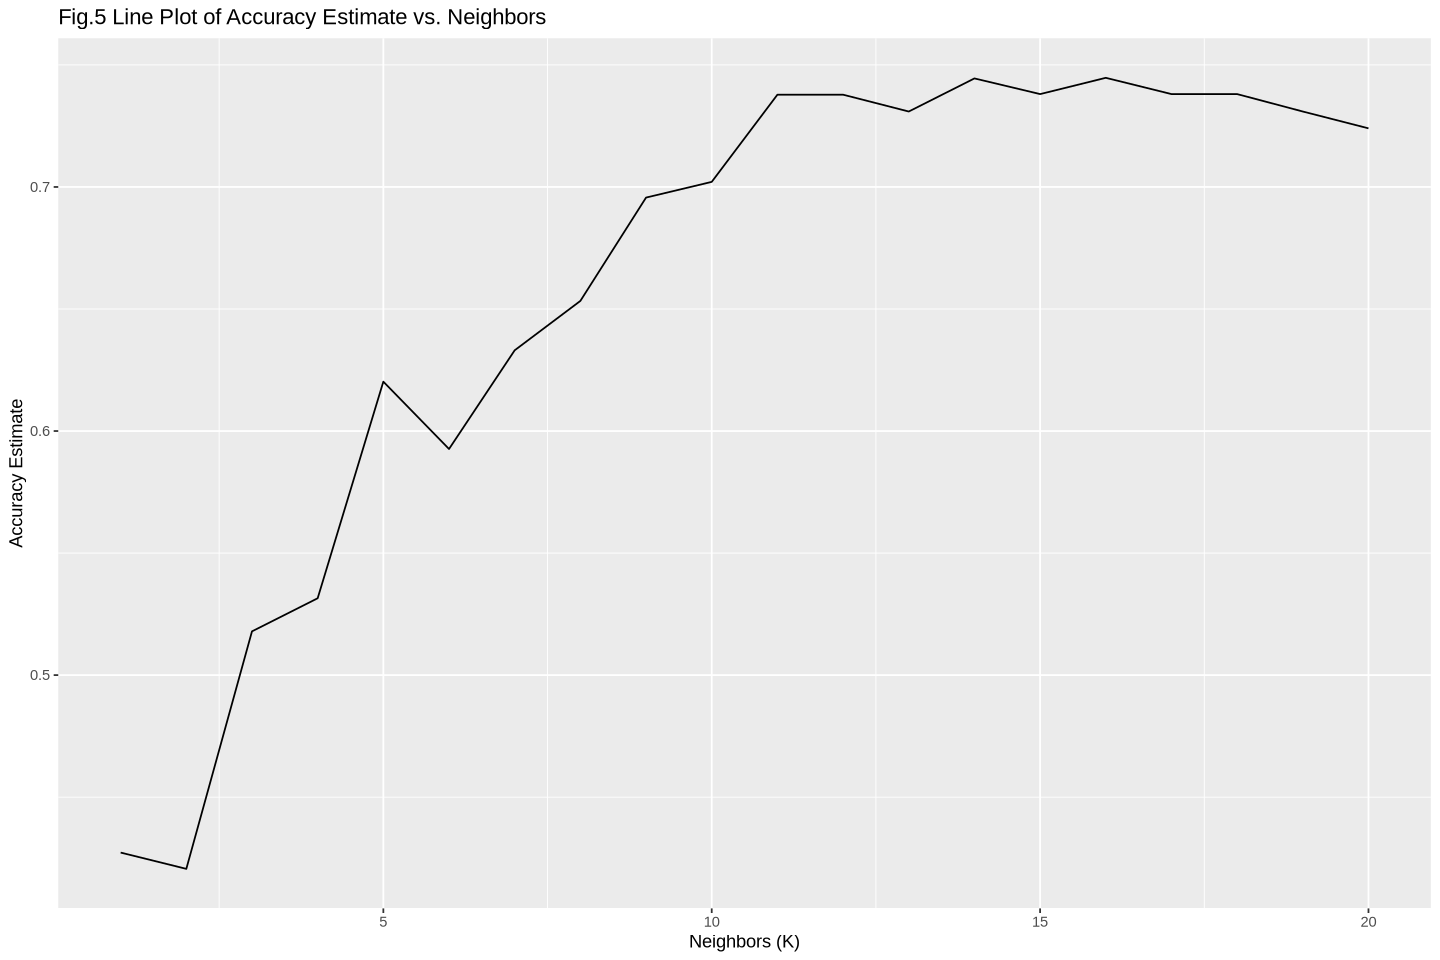

In [17]:
#Visualization for the Data Analysis Section/ How we pick our best K-Value
vis_of_best_k=best_k_value|>
    ggplot(aes(x=neighbors,y=mean))+
    geom_line()+
    labs(x="Neighbors (K)", y="Accuracy Estimate")+
    ggtitle("Fig.5 Line Plot of Accuracy Estimate vs. Neighbors")
vis_of_best_k